In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('daily_weather.parquet')

In [4]:
stockholm_data = df[df['city_name'] == 'Stockholm']

stockholm_data['date'] = pd.to_datetime(stockholm_data['date'])
stockholm_data['year'] = stockholm_data['date'].dt.year
df_2022 = stockholm_data[stockholm_data['date'].dt.year == 2022]

filtered_df = stockholm_data[['date', 'season','avg_temp_c', 'min_temp_c', 'max_temp_c', 
                              'precipitation_mm', 'avg_wind_dir_deg', 
                              'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa', 
                              'snow_depth_mm']]
#extract the month and day from the 'date' column
filtered_df['month'] = filtered_df['date'].dt.month
filtered_df['day'] = filtered_df['date'].dt.day
filtered_df['year'] = filtered_df['date'].dt.year
#reorganize the column order to have the month and day first
filtered_df = filtered_df[['date','year','month', 'day', 'season','avg_temp_c', 'min_temp_c', 'max_temp_c', 
                           'precipitation_mm', 'avg_wind_dir_deg', 
                           'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa', 
                           'snow_depth_mm']]

def create_dataset(window_size):
    filtered_df_clean = filtered_df.sort_values(by='date')
    

    #create lags for the last 10 days
    for i in range(1, window_size+1):
        filtered_df_clean[f'min_temp_c_lag_{i}'] = filtered_df_clean['min_temp_c'].shift(i)
        filtered_df_clean[f'max_temp_c_lag_{i}'] = filtered_df_clean['max_temp_c'].shift(i)
        filtered_df_clean[f'precipitation_mm_lag_{i}'] = filtered_df_clean['precipitation_mm'].shift(i)
        filtered_df_clean[f'avg_wind_speed_kmh_lag_{i}'] = filtered_df_clean['avg_wind_speed_kmh'].shift(i)
        filtered_df_clean[f'avg_sea_level_pres_hpa_lag_{i}'] = filtered_df_clean['avg_sea_level_pres_hpa'].shift(i)
        filtered_df_clean[f'snow_depth_mm_lag_{i}'] = filtered_df_clean['snow_depth_mm'].shift(i)


    filtered_df_clean = filtered_df_clean.dropna()
    return(filtered_df_clean)

filtered_df_clean=create_dataset(window_size=5).sort_values(by='date')

C:\Users\alvar\AppData\Local\Temp\ipykernel_20064\952362381.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockholm_data['date'] = pd.to_datetime(stockholm_data['date'])
C:\Users\alvar\AppData\Local\Temp\ipykernel_20064\952362381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockholm_data['year'] = stockholm_data['date'].dt.year
C:\Users\alvar\AppData\Local\Temp\ipykernel_20064\952362381.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [5]:
import torch
def create_train_test_snow(filtered_df_clean,scale=True):
    train_data = filtered_df_clean[filtered_df_clean['year'].isin([2021, 2022])]
    test_data = filtered_df_clean[filtered_df_clean['year'] == 2023]
    X_train = train_data.drop(['snow_depth_mm','min_temp_c','max_temp_c','avg_temp_c','precipitation_mm','avg_wind_speed_kmh','avg_sea_level_pres_hpa', 'date', 'season', 'year'], axis=1)
    y_train = train_data['snow_depth_mm']

    X_test = test_data.drop(['snow_depth_mm','min_temp_c','max_temp_c','avg_temp_c','precipitation_mm','avg_wind_speed_kmh','avg_sea_level_pres_hpa', 'date', 'season', 'year'], axis=1)
    y_test = test_data['snow_depth_mm']
    if scale:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    else:
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    return(X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor,train_data,test_data)

def create_train_test_temp(filtered_df_clean,scale=True):
    train_data = filtered_df_clean[filtered_df_clean['year'].isin([2021, 2022])]
    test_data = filtered_df_clean[filtered_df_clean['year'] == 2023]
    X_train = train_data.drop(['snow_depth_mm','min_temp_c','max_temp_c','avg_temp_c','precipitation_mm','avg_wind_speed_kmh','avg_sea_level_pres_hpa', 'date', 'season', 'year','month','day'], axis=1)
    y_train = train_data['avg_temp_c']

    X_test = test_data.drop(['snow_depth_mm','min_temp_c','max_temp_c','avg_temp_c','precipitation_mm','avg_wind_speed_kmh','avg_sea_level_pres_hpa', 'date', 'season', 'year','month','day'], axis=1)
    y_test = test_data['avg_temp_c']
    if scale:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    else:
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    return(X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor,train_data,test_data,X_train)



In [7]:
X_train_snow,y_train_snow, X_test_snow, y_test_snow,train_data_snow,test_data_snow=create_train_test_snow(filtered_df_clean,scale=False)
X_train_temp,y_train_temp, X_test_temp, y_test_temp,train_data_temp,test_data_temp,X_train=create_train_test_temp(filtered_df_clean,scale=False)

# Snow Prediction #

In [8]:
param_grid = {
    'n_estimators': [50, 100, 200,250],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=42)

#perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

In [9]:
grid_search.fit(X_train_snow, y_train_snow)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 250]},
             scoring='neg_mean_squared_error', verbose=2)

In [10]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

#predict using the best model
y_pred = best_model.predict(X_test_snow)

Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250}


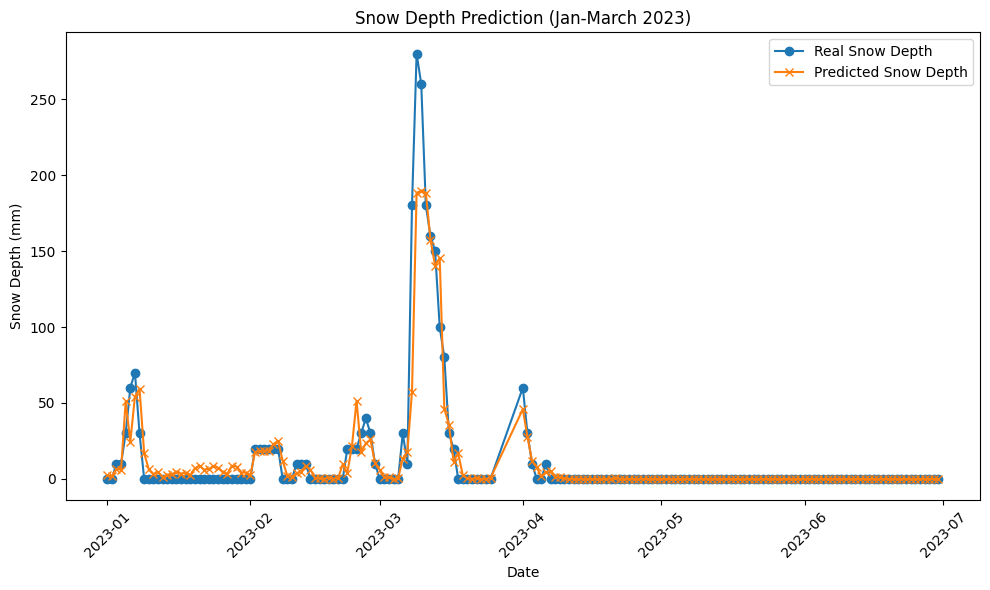

In [11]:
jan_mar_2023 = test_data_snow[(test_data_temp['date'] >= '2023-01-01') & (test_data_temp['date'] <= '2023-12-30')]

#plot predictions and actual values from January to March 2023
plt.figure(figsize=(10, 6))
plt.plot(jan_mar_2023['date'], jan_mar_2023['snow_depth_mm'], label='Real Snow Depth', marker='o')
plt.plot(jan_mar_2023['date'], y_pred, label='Predicted Snow Depth', marker='x')
plt.title('Snow Depth Prediction (Jan-March 2023)')
plt.xlabel('Date')
plt.ylabel('Snow Depth (mm)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
0.5*mean_squared_error(y_pred, jan_mar_2023['snow_depth_mm'])

110.82168180412648

In [13]:
mean_absolute_error(y_pred, jan_mar_2023['snow_depth_mm'])

5.041556273935901

# TEMP Prediction using diffrerent models #

In [14]:
param_grid = {
    'n_estimators': [200,250,300,350],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=42)

#perform grid search with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

In [15]:
grid_search.fit(X_train_temp, y_train_temp)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 250, 300, 350]},
             scoring='neg_mean_squared_error', verbose=2)

In [16]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

#predict using the best model
y_pred = best_model.predict(X_test_temp)

Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250}


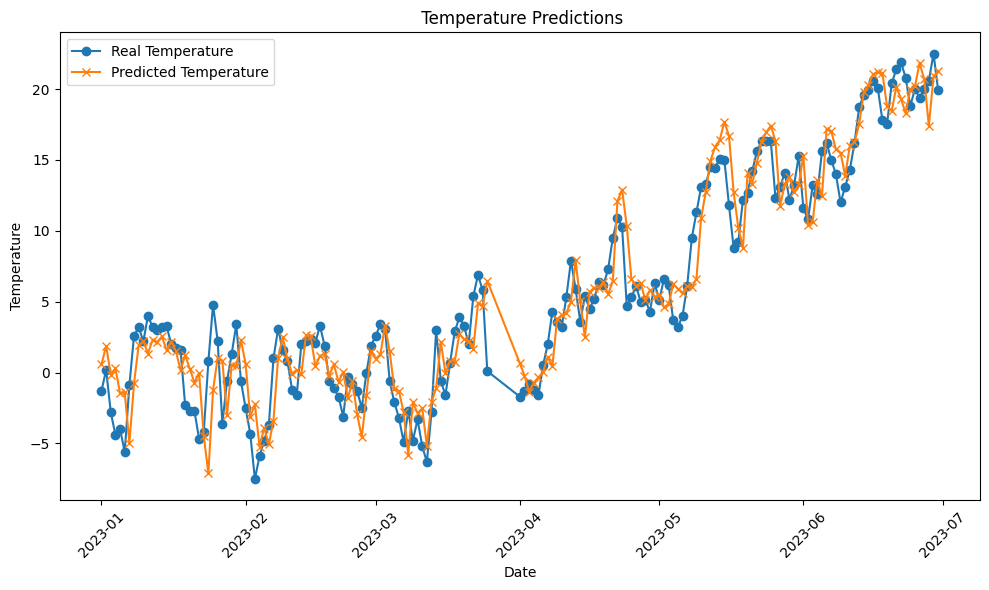

In [17]:
jan_mar_2023 = test_data_snow[(test_data_temp['date'] >= '2023-01-01') & (test_data_temp['date'] <= '2023-12-30')]

#plot predictions and actual values from January to March 2023
plt.figure(figsize=(10, 6))
plt.plot(jan_mar_2023['date'], jan_mar_2023['avg_temp_c'], label='Real Temperature', marker='o')
plt.plot(jan_mar_2023['date'], y_pred, label='Predicted Temperature', marker='x')
plt.title(' Temperature Predictions')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

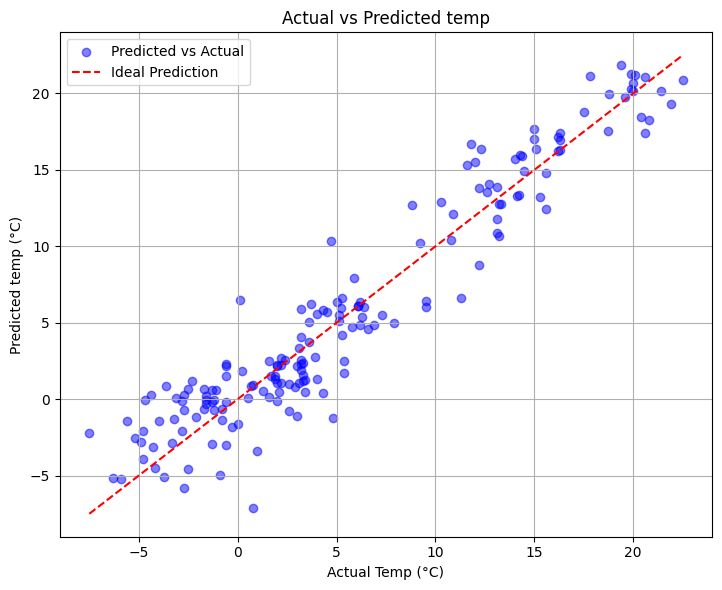

In [18]:
plt.figure(figsize=(14, 6))

#actual vs predicted for temperature
plt.subplot(1, 2, 1)
plt.scatter(jan_mar_2023['avg_temp_c'], y_pred, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([jan_mar_2023['avg_temp_c'].min(), jan_mar_2023['avg_temp_c'].max()], [jan_mar_2023['avg_temp_c'].min(), jan_mar_2023['avg_temp_c'].max()], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Actual vs Predicted temp')
plt.xlabel('Actual Temp (°C)')
plt.ylabel('Predicted temp (°C)')
plt.legend()
plt.grid()



plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
mean_absolute_error(y_pred, jan_mar_2023['avg_temp_c'])

1.8114777697694935

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
X = jan_mar_2023['avg_temp_c'].values.reshape(-1, 1)  #feature (independent variable)
y = y_pred  #target (dependent variable)

#vreate a LinearRegression model
model = LinearRegression()

#fit the model
model.fit(X, y)

#make predictions
y_pred = model.predict(X)

#calculate the R^2 score
r2 = r2_score(y, y_pred)

print(f"R² score: {r2}")

R² score: 0.9115325456984474


In [21]:
best_rf = grid_search.best_estimator_
feature_importances = best_rf.feature_importances_

#assuming your features are in a DataFrame X_train_snow, get feature names
#if X_train_snow is a DataFrame, we can get the column names
features = X_train.columns

#create a DataFrame for better visualization
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

#sort the features by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

#display the most important features
print(importances_df)

                         Feature  Importance
1               min_temp_c_lag_1    0.674405
2               max_temp_c_lag_1    0.271099
0               avg_wind_dir_deg    0.010196
7               min_temp_c_lag_2    0.004385
13              min_temp_c_lag_3    0.004096
26              max_temp_c_lag_5    0.003342
19              min_temp_c_lag_4    0.003140
14              max_temp_c_lag_3    0.002958
20              max_temp_c_lag_4    0.002870
5   avg_sea_level_pres_hpa_lag_1    0.002469
8               max_temp_c_lag_2    0.002417
4       avg_wind_speed_kmh_lag_1    0.002027
29  avg_sea_level_pres_hpa_lag_5    0.001900
25              min_temp_c_lag_5    0.001621
10      avg_wind_speed_kmh_lag_2    0.001531
22      avg_wind_speed_kmh_lag_4    0.001498
16      avg_wind_speed_kmh_lag_3    0.001415
11  avg_sea_level_pres_hpa_lag_2    0.001190
23  avg_sea_level_pres_hpa_lag_4    0.001097
28      avg_wind_speed_kmh_lag_5    0.001002
17  avg_sea_level_pres_hpa_lag_3    0.000921
21        